In [1]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


df=pd.read_csv('./data/051910.csv',index_col=0).reset_index(drop=True)
# df=pd.read_csv('./data/215600.csv',index_col=0).reset_index(drop=True)
code_name=pd.read_csv('./data/code_name.csv')
train=df[['open','high','low','volume']]
target=df[['close']]
dates=df.date

In [16]:
def preprocessing(data):
    
    scaler= StandardScaler()
    data=scaler.fit_transform(data)
    data=np.array(data)
    
    return data,scaler
    
def split_data(data):
    
    prop=len(data)//5
    val=data[:prop]
    test=data[prop+1:2*prop]
    train=data[2*prop:]
    
    return np.array(train),np.array(val),np.array(test)

def make_seq(data,window_size):
    seq_data=[]
    for i in range(data.shape[0]-window_size):
        L=data[i:i+window_size]
        seq_data.append(L)
    return seq_data

def make_nomarlized_seq(data,window_size):
    '''input : pandas df, window size만큼만 normalize'''
    seq_data=[]
    scaler= StandardScaler()
    for i in range(data.shape[0]-window_size):
        L=data[i:i+window_size]
        seq_data.append(scaler.fit_transform(np.array(L)))
        
    return np.array(seq_data),scaler

In [19]:
# train_data_normalized,scaler_train = preprocessing(train.iloc[:-1])
# target_data_normalized ,scaler_test= preprocessing(target.iloc[1:])

# train_seq=make_seq(train_data_normalized,window_size=5)
# target_seq=make_seq(target_data_normalized,window_size=5)

'''making normalized window'''
train_seq,train_scaler=make_nomarlized_seq(train.iloc[:-1],window_size=5)
test_seq,test_scaler=make_nomarlized_seq(target.iloc[1:],window_size=5)

x_train,x_val,x_test=split_data(train_seq)
y_train,y_val,y_test=split_data(target_seq)

### LSTM을 이용한 예측

In [20]:
class stock_net(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        
        super(stock_net, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.h_o=nn.Linear(hidden_dim,1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        
        x=self.lstm(x)
        x=self.relu(self.h_o(x[0]))
        
        return x

In [21]:
emb_dim=x_train.shape[2] # feature size

In [22]:
haha_net=stock_net(emb_dim,10)
criterion = nn.MSELoss()
# Optimizer를 생성합니다.
optimizer = optim.SGD(haha_net.parameters(), lr=0.001)

In [ ]:
Loss=[]
epoch=1
for y in range(epoch):
    for i in range(x_train.shape[0]):

        optimizer.zero_grad()
        output=haha_net(torch.FloatTensor(x_train[i]).view(5,-1,4))
        loss = criterion(output, torch.FloatTensor(y_train[i]))
        loss.backward()
        optimizer.step()  
        if i%100==0:
            Loss.append(loss.item())
            print('epoch/step',y,i,':',loss.item())

C:\Users\limaries30\.conda\envs\python3.6\lib\site-packages\torch\nn\modules\loss.py:443: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch/step 0 0 : 0.73527592420578
epoch/step 0 100 : 0.6580135822296143
epoch/step 0 200 : 0.11120356619358063
epoch/step 0 300 : 0.0425124391913414
epoch/step 0 400 : 0.309242308139801
epoch/step 0 500 : 0.820602536201477
epoch/step 0 600 : 2.056516647338867
epoch/step 0 700 : 2.8003721237182617
epoch/step 0 800 : 0.19761449098587036
epoch/step 0 900 : 0.004151420667767525
epoch/step 0 1000 : 0.03996511176228523
epoch/step 0 1100 : 0.008763221092522144


In [44]:
Prediction=[]
for i in x_test:
    prediction=haha_net(torch.FloatTensor(i).view(5,-1,4))
    Prediction.append(prediction.view(-1).detach().numpy()[-1])  #many to many 라 마지막 종가만 추가

In [45]:
Prediction=np.array(Prediction).reshape(-1)
print(Prediction.shape)

(921,)


In [46]:
prediction=scaler_test.inverse_transform(Prediction.reshape(-1,1))
prediction=pd.DataFrame(prediction,columns={'prediction'})

In [47]:
comparing=pd.concat([prediction,target.iloc[-y_test.shape[0]:].reset_index(drop=True)],axis=1)
comparing.index = pd.to_datetime(dates.iloc[-y_test.shape[0]:])

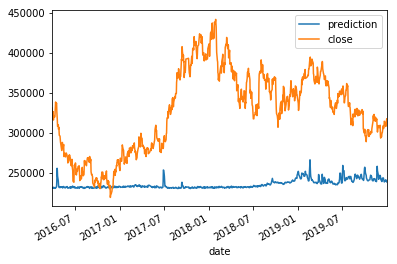

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

comparing[['prediction','close']].plot()

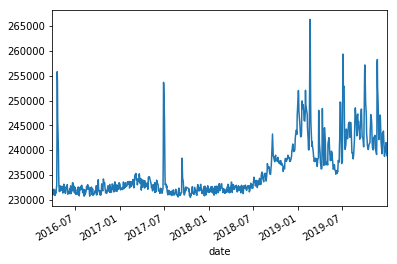

In [49]:
comparing['prediction'].plot()